In [1]:
import os
from six import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
import tensorflow as tf
import tensorflow_hub as hub
from tqdm import tqdm
from PIL import Image, ImageColor, ImageDraw, ImageFont, ImageOps

W0618 20:21:35.112999 4489393600 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [2]:
def format_prediction_string(image_id, result):
    prediction_strings = []
    
    for i in range(len(result['detection_scores'])):
        class_name = result['detection_class_names'][i].decode("utf-8")
        boxes = result['detection_boxes'][i]
        score = result['detection_scores'][i]
        
        prediction_strings.append(f"{class_name} {score} " + " ".join(map(str, boxes)))
        
    prediction_string = " ".join(prediction_strings)

    return { "ImageID": image_id, "PredictionString": prediction_string}

In [3]:
#Display image
def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)

In [4]:
#drawing
def draw_bounding_box_on_image(image, ymin, xmin,ymax, xmax, color, font,thickness=4,display_str_list=()):
    """Adds a bounding box to an image."""
    
    #Target image for fraw
    draw = ImageDraw.Draw(image)
    
    #Get size of original image
    im_width, im_height = image.size
    
    #resize result to orignal
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,  ymin * im_height, ymax * im_height)
    
    #draw line
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
              width=thickness,
              fill=color)

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height
        
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        
        #set lengths
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        
        #write string and belt
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin
        
    ### In python, pass reference!!! in this type of variance ###
        
        

#Extract detection result and draw
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    
    #Get Colormap
    colors = list(ImageColor.colormap.values())

    #Get font data
    try:
        font = ImageFont.truetype(
            "/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
            25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    #Extract each result boxs
    for i in range(min(boxes.shape[0], max_boxes)):#max 10
        
        #if score is low then detecion is fault
        if scores[i] >= min_score: 
            
            #expand cood
            ymin, xmin, ymax, xmax = tuple(boxes[i].tolist())
            
            #shaping for displaying score, class
            display_str = "{}: {}%".format(class_names[i].decode("ascii"), int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]#random
            
            #Convert original image data to RGB
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
                image_pil,
                ymin,
                xmin,
                ymax,
                xmax,
                color,
                font,
                display_str_list=[display_str])
            
            np.copyto(image, np.array(image_pil))
            
    return image

In [6]:
sample_image_path = "../../test/00000b4dcff7f799.jpg"

with tf.Graph().as_default():
    # Create our inference graph
    
    # set placeholder as string
    image_string_placeholder = tf.placeholder(tf.string) 
    
    # decode image
    decoded_image = tf.image.decode_jpeg(image_string_placeholder) 
    
    #Convert image to float
    decoded_image_float = tf.image.convert_image_dtype(image=decoded_image, dtype=tf.float32)
    
    # Expanding image from (height, width, 3) to (1, height, width, 3) axis = 0 
    image_tensor = tf.expand_dims(decoded_image_float, 0)

    # Load the model from tfhub.dev, and create a detector_output tensor
    model_url = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1"
    
    #hub means tensor flow hub. load model
    #hub is used for simple detection using already trained model 
    detector = hub.Module(model_url)
    
    #detect and output result
    detector_output = detector(image_tensor, as_dict=True)
    
    # Initialize the Session
    # initialize valiable and table which is for output
    init_ops = [tf.global_variables_initializer(), tf.tables_initializer()]
    
    #build graph
    sess = tf.Session()
    
    #run session
    sess.run(init_ops)

    # Load our sample image into a binary string
    with tf.gfile.Open(sample_image_path, "rb") as binfile:
        image_string = binfile.read()

    # Run the graph we just created
    # feed dict : replacer!
    result_out, image_out = sess.run([detector_output, decoded_image],feed_dict={image_string_placeholder: image_string})
    # result_out : detect result { [ coods of box],[names of class] ,[scores of detection] }
    # image_out : image
    
    
    

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0618 20:23:12.019270 4489393600 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0618 20:23:17.341578 4489393600 saver.py:1483] Saver not created because there are no variables in the graph to restore


Font not found, using default font.


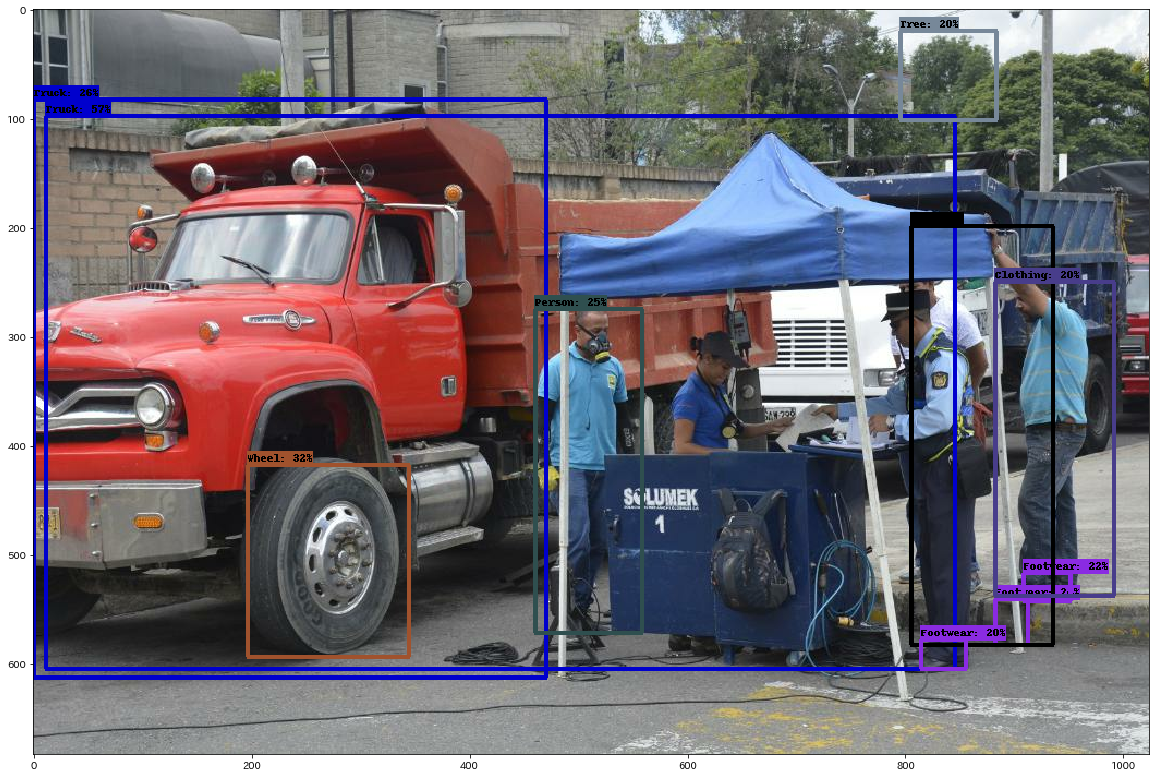

In [7]:


image_with_boxes = draw_boxes(
    np.array(image_out), result_out["detection_boxes"],
    result_out["detection_class_entities"], result_out["detection_scores"])

#display image
display_image(image_with_boxes)
